# ANALYZE DATA

In [1]:
# Load all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as sci
%matplotlib inline
sns.set_palette("colorblind")
sns.set_context("talk")
sns.set(style = "dark", rc={'figure.figsize':(11.7,8.27)})

## Import The Dataset

In [2]:
# Import the cleaned dataset
sales_clean = pd.read_csv("clean_datasets/sales_clean.csv", 
                          dtype={"category":"category", "gender":"category"},
                          parse_dates=["date"])
sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     336816 non-null  int64         
 1   date        336816 non-null  datetime64[ns]
 2   session_id  336816 non-null  int64         
 3   client_id   336816 non-null  int64         
 4   category    336816 non-null  category      
 5   price       336816 non-null  float64       
 6   gender      336816 non-null  category      
 7   age         336816 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(4)
memory usage: 16.1 MB


## Univariate Analysis 

Now that all the datasets are cleaned we can make some analysis. 


### **What is the Average Price of the Sales?**

In [3]:
sales_clean.price.describe()

count    336816.000000
mean         17.214175
std          17.852809
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

We have an average price of **17.22** but with a standard deviation of **17.85** which means that there are too much variability between the prices, there are probably outliers. Let's check for the IQR.  

In [4]:
# IQR of the price
def iqr(column) -> float:
    """return the iqr of a given column"""
    return column.quantile(.75) - column.quantile(.25)
# IQR of the price
iqr(sales_clean.price)

10.379999999999999

We have an IQR of around **10**, the variability is high. Let's make a plot.

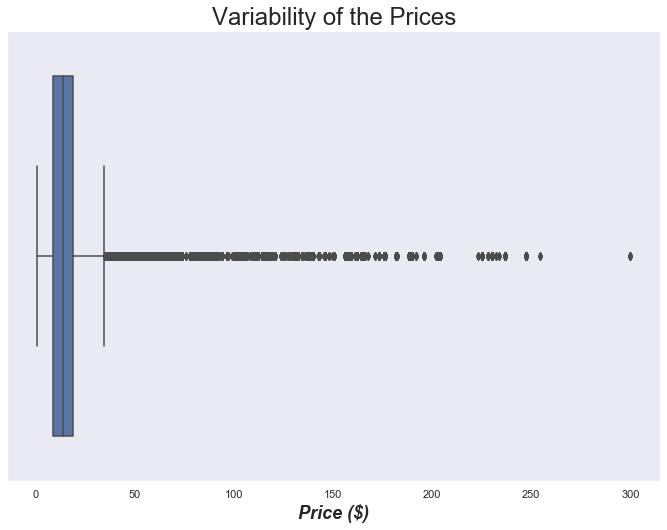

In [5]:
# Boxplot to see the variability
sns.boxplot("price", data = sales_clean)
plt.title("Variability of the Prices", fontsize = 24)
plt.xlabel("Price ($)", fontsize = 18, fontweight = "bold", fontstyle = "italic")
plt.savefig("images/boxplot_price.svg")

As we can see there are many outliers. Let's try to find them all. 

In [6]:
# Find all the positive outliers, Q3 + 1.5IQR
outliers = sales_clean.price.quantile(0.75)+1.5*iqr(sales_clean.price)
sales_clean.price[sales_clean.price > outliers].sort_values()

34429      34.77
155477     34.77
262595     34.77
162605     34.77
62627      34.77
           ...  
334751    300.00
50216     300.00
115097    300.00
281102    300.00
303214    300.00
Name: price, Length: 20423, dtype: float64

All the price between **34.77** to **300** are outliers. 

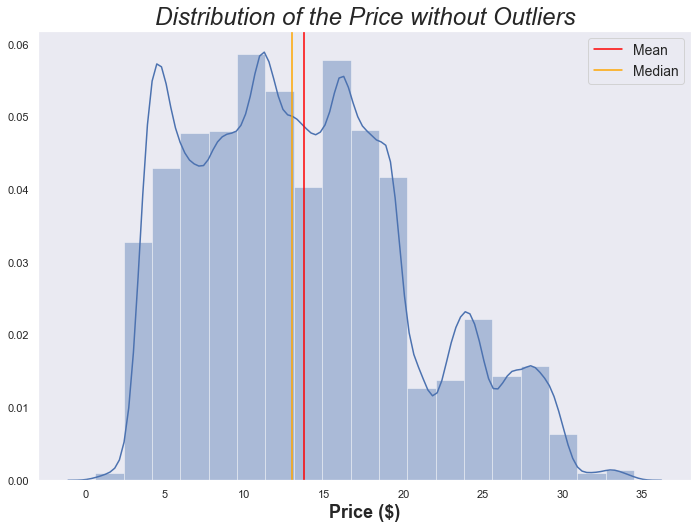

In [7]:
# Distribution of the non outliers values
sales_clean_no_outliers = sales_clean[sales_clean.price < outliers] # Compute the dataframe of the non outliers
bins = int(round(1 + np.log2(sales_clean_no_outliers.shape[0]))) # Optimal number of bins
sns.distplot(sales_clean_no_outliers.price, bins = bins) # Distribution plot of the non outliers values
plt.axvline(sales_clean_no_outliers.price.mean(), color = "red") # Plot vertical line of the mean
plt.axvline(sales_clean_no_outliers.price.median(), color = "orange") # Plot the vertical line of the median
plt.legend(["Mean", "Median"], fontsize = 14)
plt.title("Distribution of the Price without Outliers", fontsize = 24, fontstyle = "italic")
plt.xlabel("Price ($)", fontsize = 18, fontweight = "bold")
plt.savefig("images/hist_price_no_out.svg");

In [8]:
sales_clean_no_outliers.price.agg([np.mean, np.median])

mean      13.721993
median    12.990000
Name: price, dtype: float64

If we remove all the outliers the mean and median are almost the same and are around $13. 

In [9]:
# check the proportion of outliers in the dataframe
sales_clean_outliers = sales_clean.price[sales_clean.price > outliers]
prop_outliers = len(sales_clean_outliers) / len(sales_clean) * 100
prop_outliers

6.063548049973873

The outliers represent about **6%** of the number of sales. Let see what it represent as value

In [10]:
# total sales for the outliers
outliers_total_sales = sales_clean_outliers.sum() / sales_clean.price.sum() * 100
outliers_total_sales

25.120122475412238

Even if the outliers represent just **6%** of the sales, they represent **25%** of the total purchases amount.

In [11]:
# mean, median and mode of the price in the dataframe
print("mean : ",sales_clean.price.mean())
print("median : ",sales_clean.price.median())
print("mode : ",sales_clean.price.mode()[0])

mean :  17.21417471267639
median :  13.9
mode :  15.99


We confirm here that most of the sales are between **0 and 16**, with highest sales at **13.9**

### **Concentration of sales - Lorenz Curve**

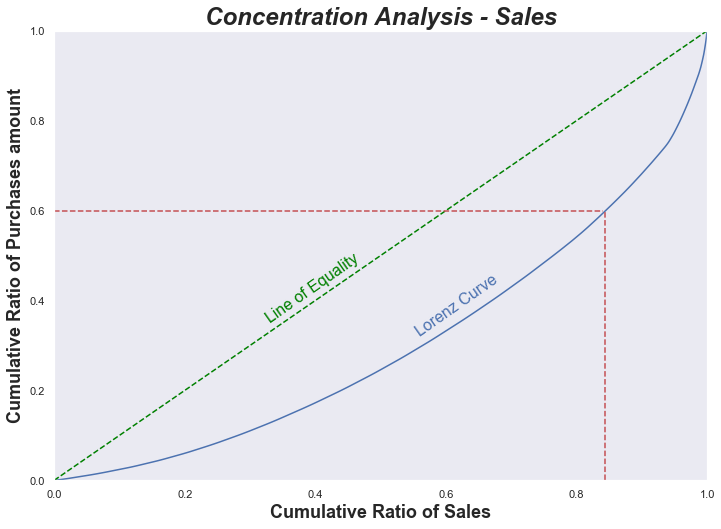

In [12]:
# Plot the lorenz curve
n = len(sales_clean.price) #size of the sample
lorenz = np.cumsum(np.sort(sales_clean.price) / sales_clean.price.sum()) #result will be an array
lorenz = np.append([0], lorenz) #values of the y axis on the curve, the curve will begin at 0

# plt.axes().axis("equal") #x and y axis will have the same length
xaxis = np.linspace(-1/n, 1+1/n, n+1) #values of the x axis on the curve
plt.plot(xaxis, lorenz, drawstyle = "steps-post") # Plot lorenz curve
plt.plot(xaxis, xaxis, linestyle="--", color = "green") # Plot the 1st bissector
plt.xlim(0,1) # To make the axis starting at 0
plt.ylim(0,1)
plt.ylabel("Cumulative Ratio of Purchases amount", fontsize = 18, fontweight = "bold")
plt.xlabel("Cumulative Ratio of Sales", fontsize = 18, fontweight = "bold")
plt.axvline(0.843, ymax = 0.6, linestyle = "--", color = "r") # Plot vertical and horizontal line
plt.axhline(0.6, xmax = 0.84, linestyle = "--", color = "r")  #
plt.title("Concentration Analysis - Sales", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.text(s = "Line of Equality", y = 0.35, x = 0.32, rotation = 35, fontsize = 16, color = "green")
plt.text(s = "Lorenz Curve", y = 0.32, x = 0.55, rotation = 35, fontsize = 16, color = "b")
plt.savefig("images/lorenz_curve.svg");

#### **Gini Coefficient**

In [13]:
# compute gini coefficient
AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n # Area under the curve
S = 0.5 - AUC # Area between the curve and the 1st bissector
gini = round(2*S,1)*100
gini

40.0

We have a gini coefficient of around 40%, which means there is inequality.
Bottom 84% of the sales just give 60% of the total purchases amount.

### **Which is the categories with more sales?**

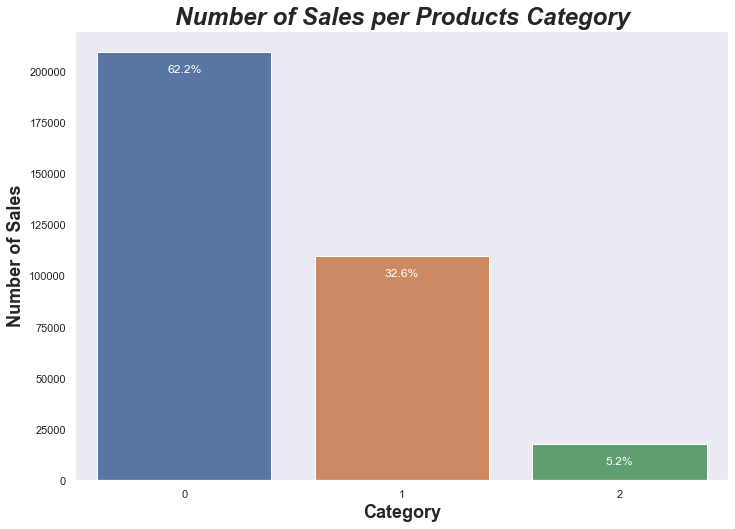

In [14]:
# Barplot of the categories
sns.countplot(data = sales_clean, x = "category")
plt.title("Number of Sales per Products Category", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.xlabel(xlabel = "Category", fontsize = 18, fontweight = "bold")
plt.ylabel(ylabel = "Number of Sales", fontsize = 18, fontweight = "bold")
# Add some annotations
number_points = sales_clean.shape[0]        # number of points in the dataset
category_counts = sales_clean.category.value_counts() # all Values of the categories
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'white')
plt.savefig("images/sales_by_category.svg")

**62%** of the sales are in category 0, **33%** in category 1 and just **5.2%** in category 2. 

### **What is the Customer's Age with highest purchases**

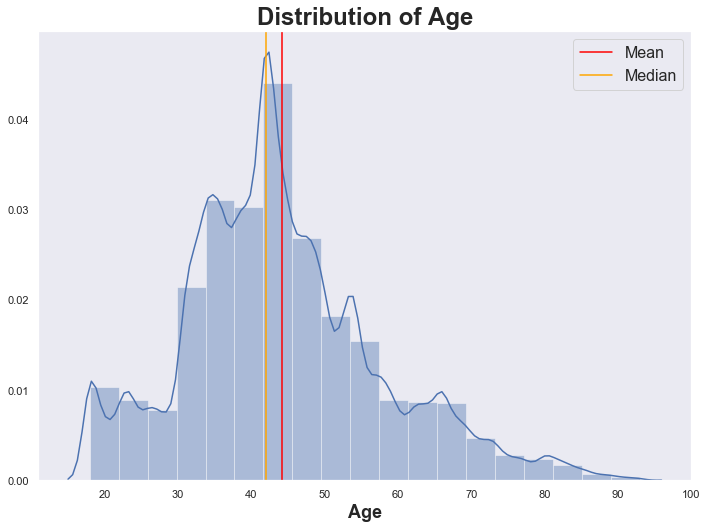

In [15]:
# Plot age distribution
bins_sales_clean = int(round(1 + np.log2(sales_clean.shape[0])))# Optimal number of bins
sns.distplot(sales_clean.age, bins = bins_sales_clean) # Distribution plot
plt.xlabel("Age", fontsize = 18, fontweight = "bold")
plt.title("Distribution of Age", fontsize = 24, fontweight = "bold")
plt.axvline(sales_clean.age.mean(), color = "red")
plt.axvline(sales_clean.age.median(), color = "orange")
plt.legend(["Mean", "Median"], fontsize = 16)
plt.savefig("images/hist_age.svg");

## Bivariate Analysis

### **What is the Average price in each category?**

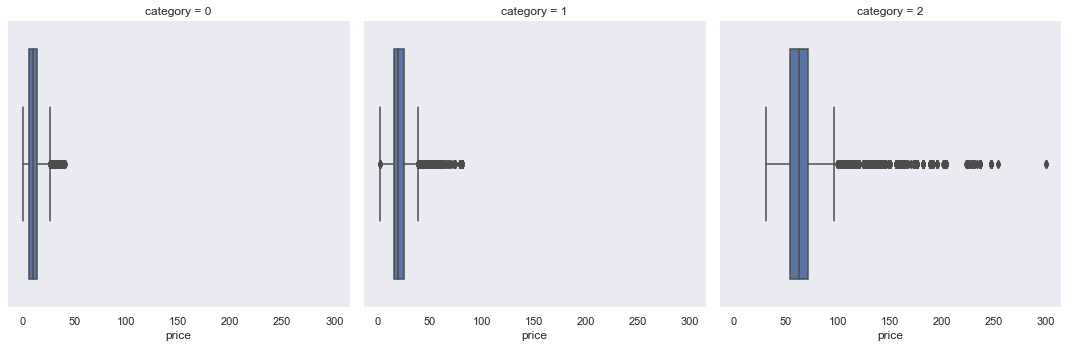

In [16]:
# Considering all the dataframe
sns.catplot(x = "price", data = sales_clean, kind = "box", col = "category");

In [17]:
for i in range(3):
    print("Mean Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].mean())
    print("Median Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].median())
    print("Mode Category " + str(i) + ": ", sales_clean.price[sales_clean.category == str(i)].mode()[0])
    print("Standard Deviation Category " + str(i) + ":", sales_clean.price[sales_clean.category == str(i)].std(),"\n")    

Mean Category 0:  10.648427425323296
Median Category 0:  9.99
Mode Category 0:  4.99
Standard Deviation Category 0: 4.929345339563638 

Mean Category 1:  20.4801058003428
Median Category 1:  19.08
Mode Category 1:  15.99
Standard Deviation Category 1: 7.568956079961025 

Mean Category 2:  75.17494929352519
Median Category 2:  62.83
Mode Category 2:  68.99
Standard Deviation Category 2: 39.0799988187327 



The average price in category `0 is $10, in category 1 it is $19 and in category 2 it is $62`. 
There are many outliers in all categories. we take as average the median.

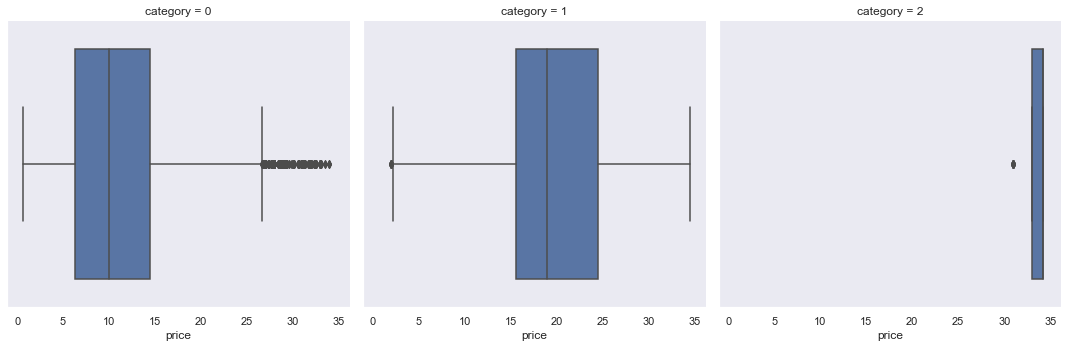

In [18]:
# Average sales in each category removing outliers
sns.catplot(x = "price", data = sales_clean_no_outliers, kind = "box", col = "category");

In [19]:
# measures of center df without outliers
for i in range(3):
    print("Mean Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].mean())
    print("Median Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].median())
    print("Mode Category " + str(i) + ": ", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].mode()[0])
    print("Standard Deviation Category " + str(i) + ":", sales_clean_no_outliers.price[sales_clean_no_outliers.category == str(i)].std(),"\n")

Mean Category 0:  10.63737482155133
Median Category 0:  9.99
Mode Category 0:  4.99
Standard Deviation Category 0: 4.9006383705794745 

Mean Category 1:  19.751837108982308
Median Category 1:  18.99
Mode Category 1:  15.99
Standard Deviation Category 1: 5.939520677816348 

Mean Category 2:  33.504698795180715
Median Category 2:  34.23
Mode Category 2:  34.23
Standard Deviation Category 2: 1.181694047883549 



It seems that all the outiers values are from product of category 2. Product of category 2 are the most expensives.

Most of the sales come from people aged between 30 and 55 with a peak at 42 years old.

### **Sales by Gender**

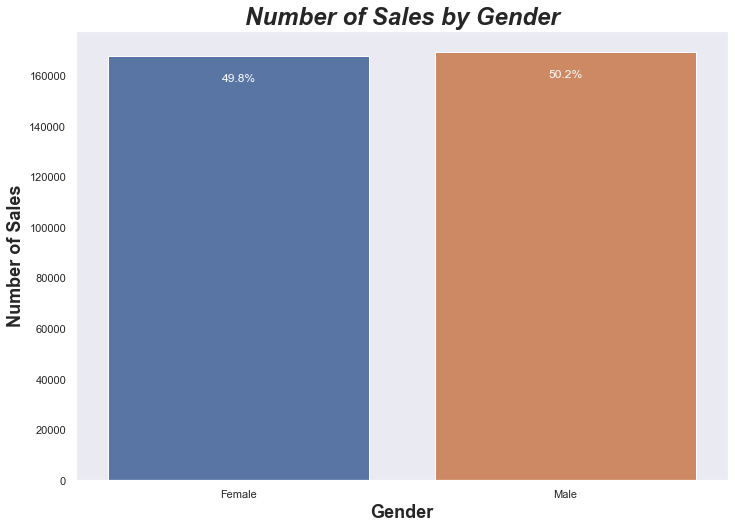

In [20]:
# Barplot of the categories
sns.countplot(data = sales_clean, x = "gender")
plt.title("Number of Sales by Gender", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.xlabel(xlabel = "Gender", fontsize = 18, fontweight = "bold")
plt.ylabel(ylabel = "Number of Sales", fontsize = 18, fontweight = "bold")
# Add some annotations
number_points = sales_clean.shape[0]        # number of points in the dataset
category_counts = sales_clean.gender.value_counts() # all Values of each category
locs, labels = plt.xticks()   # Current tick locations and labels
# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(x = loc, y = count-10000, s = percentage, ha = 'center', color = 'white')
plt.savefig("images/sales_by_gender.svg")

The number of sales is almost the same for each gender.

### **Sales over time**

Check all the date availaible.

In [21]:
# Check the years 
sales_clean.date.dt.year.unique()

array([2021, 2022], dtype=int64)

In [22]:
# Check the last date of 2022
sales_clean.date.max()

Timestamp('2022-02-28 23:59:58.040472')

We have data for 2021 and 2022. For 2022 we have just January and February.

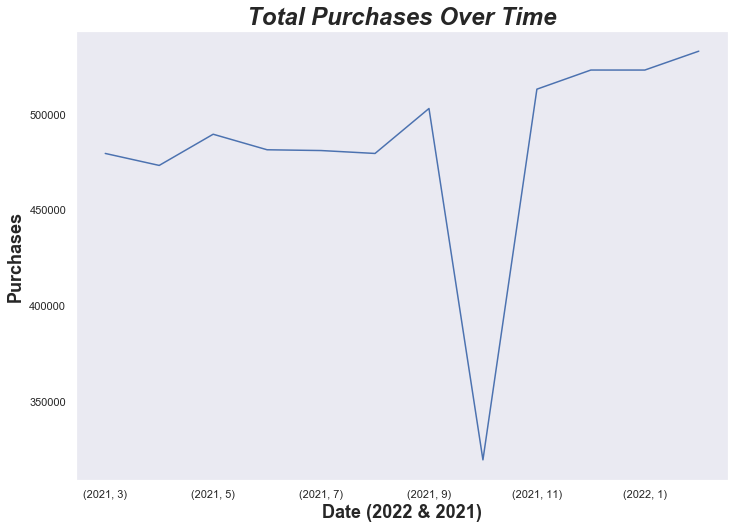

In [23]:
# Time series of the price each month just for 2021
sales_over_time = sales_clean.copy()
sales_over_time["year"] = sales_over_time.date.dt.year # Create year variable
sales_over_time["month"] = sales_over_time.date.dt.month # Create month variable
sales_over_time.groupby(["year", "month"]).price.sum().plot()# Plot sales over time
plt.title("Total Purchases Over Time", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.xlabel("Date (2022 & 2021)", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.savefig("images/sales_over_time.svg");

In 2021 December is the month with the most sales, while October is the worse. Overall february is the month with the most sales.
There is a high drop in october, let's go deep to see what is really happening.

#### **Sales in October 2021**

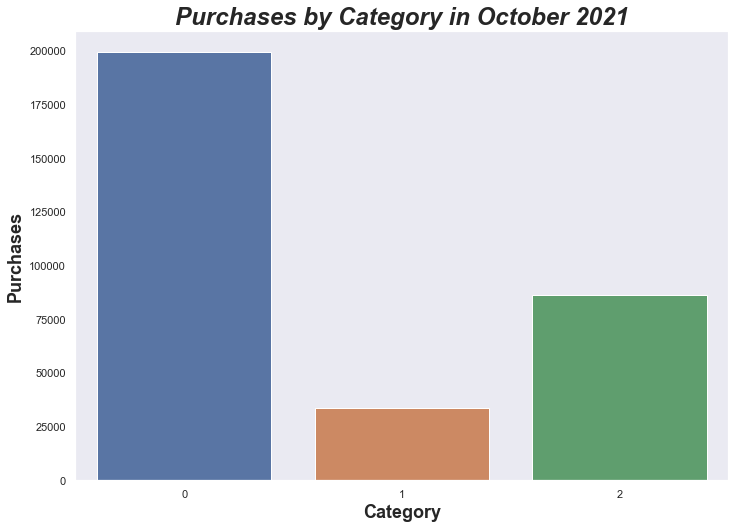

In [24]:
# Compute the dataframe with just october
sales_clean_oct = sales_clean[sales_clean.date.dt.month == 10]
# Group by category 
g_oct = sales_clean_oct.groupby("category").price.sum().reset_index()
sns.barplot("category", "price", data = g_oct)
plt.xlabel("Category", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Purchases by Category in October 2021", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.savefig("images/october_category.svg");

The Sales in October are very low for the category 1, let's go deep by checking each day of that month.

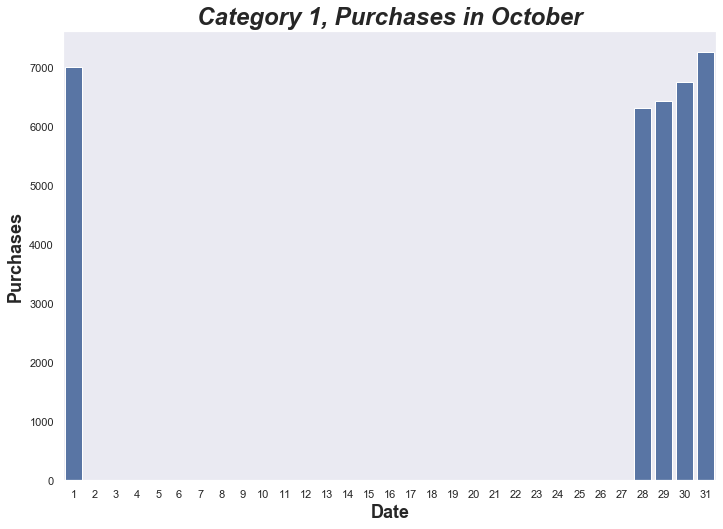

In [25]:
# Dataframe of all the days of october, we group by category and days
sales_oct = sales_clean_oct.groupby(["category", sales_clean_oct.date.dt.day]).sum().reset_index()
# Filter just for category 1
sales_oct_1 = sales_oct[sales_oct.category == "1"]
sns.barplot("date", "price",data = sales_oct_1, color = "b")
plt.xlabel("Date", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Category 1, Purchases in October", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.savefig("images/october_days.svg");

We can clearly see that from the 2th to the 27th there were no sales. Maybe there was a lack of product that period, this is to investigate.

#### **What is the day of the week with the most sales over time?**

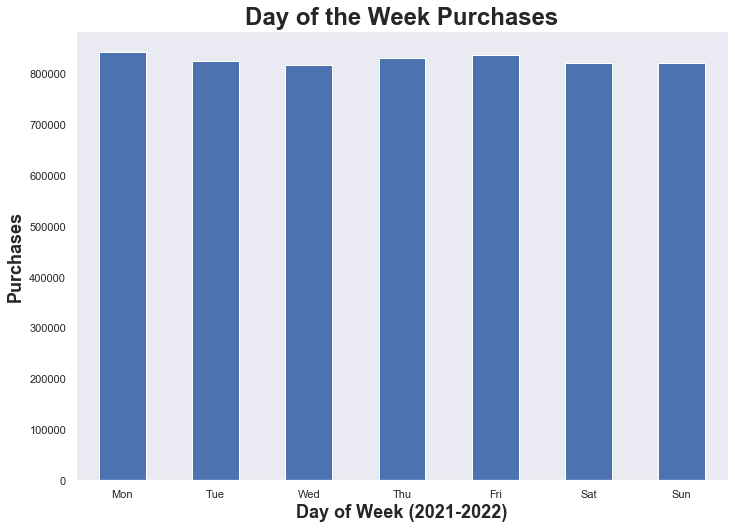

In [26]:
# Group by day and plot
sales_clean.groupby(sales_clean.date.dt.dayofweek).price.sum().plot(kind = "bar")
plt.xlabel("Day of Week (2021-2022)", fontsize = 18, fontweight = "bold")
plt.ylabel("Purchases", fontsize = 18, fontweight = "bold")
plt.title("Day of the Week Purchases", fontsize = 24, fontweight = "bold")
plt.xticks([0,1,2,3,4,5,6],["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation = 0)
plt.savefig("images/days_of_week.svg");

All the days of the week have almost the same amount of purchases, so there is not a better day for sales.

## Correlations

### **Correlation between Gender and Category**

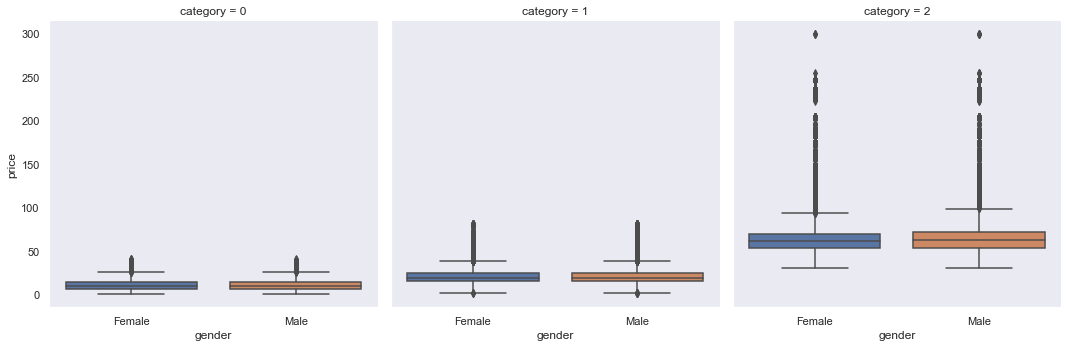

In [27]:
# boxplot, gender and categories of products purchased
sns.catplot(x = "gender", y = "price", col = "category", kind = "box" , data = sales_clean);

We can see that in each category gender are almost simmetrical, this means that there is no difference of purchase between gender in each category.

Our hypothesis.
>   H0 : Gender and Category are independant  
    H1: Gender and Category are dependant

In [28]:
# Function to find the dependence of 2 variables
def chi_squared(df, ind, col)-> str:
    """ Show if 2 variables of a dataframe are dependent or not"""
    # Contigency table
    contingency_table = pd.crosstab(index = df[ind], columns = df[col])
    stat, p, dof, expected = sci.chi2_contingency(contingency_table)
    if p > 0.01:
        return "{} and {} are probably independent".format(ind, col), contingency_table
    else:
        return "{} and {} are probably dependent".format(ind, col), contingency_table

In [29]:
# Find if the 2 variables are dependent
result, table = chi_squared(sales_clean, "category", "gender")

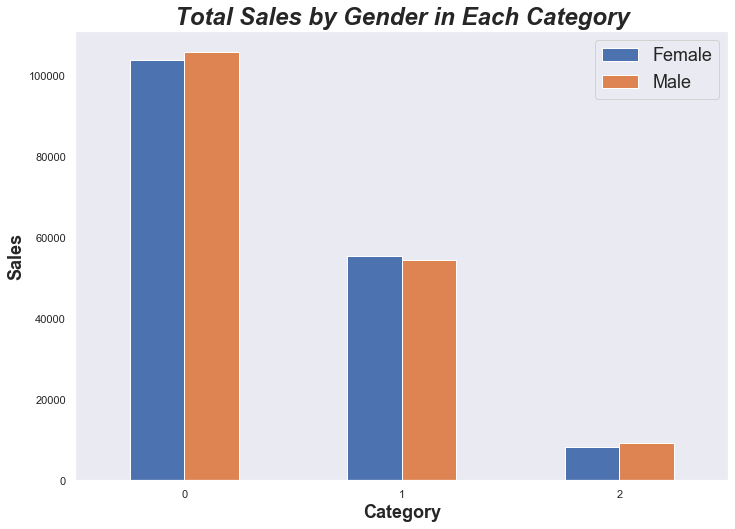

In [30]:
table.plot(kind="bar", rot= 0)
plt.title("Total Sales by Gender in Each Category", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.xlabel("Category", fontsize = 18, fontweight = "bold")
plt.ylabel("Sales", fontsize = 18, fontweight = "bold")
plt.legend(fontsize = 18, loc = "upper right")
plt.savefig("images/gender_by_category.svg");

In [31]:
# Print the result of the test
result

'category and gender are probably dependent'

There are more sales in category 0 and very few in category 2, even if category sales 2 has products with higher prices.   
In category **0** *Male* make more purchases than *Female*.  
In category **1** *Female* make more purchases than *Male*.  
In category **2** *Male* make more purchases than *Female*. 

### **Correlation between age and total amount of purchases**

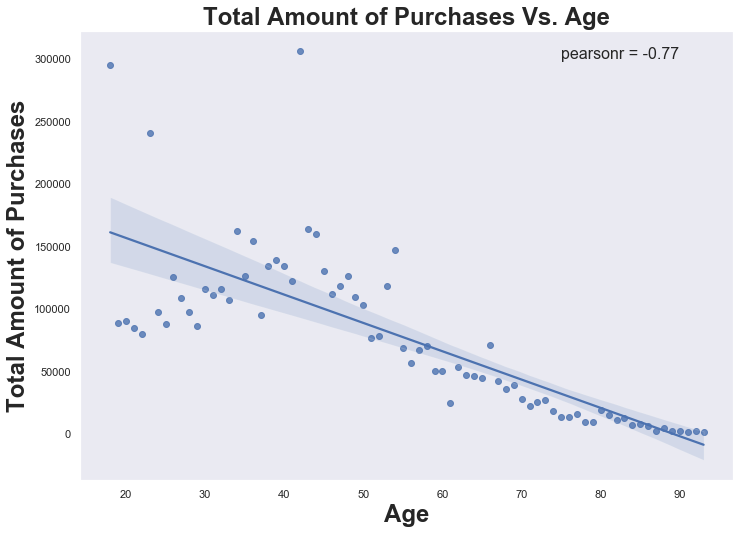

In [32]:
# Create a dataframe with age and the total amount purchases
corr_age_price = sales_clean.groupby("age").sum().reset_index()
# Compute the pearsonr 
r_age_price = sci.pearsonr(corr_age_price.price, corr_age_price.age)[0]
# Plot using regplot
sns.regplot(x = "age", y = "price", data = corr_age_price)
plt.xlabel("Age", fontsize = 24, fontweight = "bold")
plt.ylabel("Total Amount of Purchases", fontsize = 24, fontweight = "bold")
plt.title("Total Amount of Purchases Vs. Age", fontsize = 24, fontweight = "bold")
plt.text(s = "pearsonr = {:.2f}".format(r_age_price), y = 300000, x = 75, fontsize = 16);


There is a strong negative correlation between the age and the amount of purchases, as the age increases the amount of purchases decreases.  
Young people buy more than old people. 

### **Correlation between Age and the Purchase frequency(Number of purchases per month)**

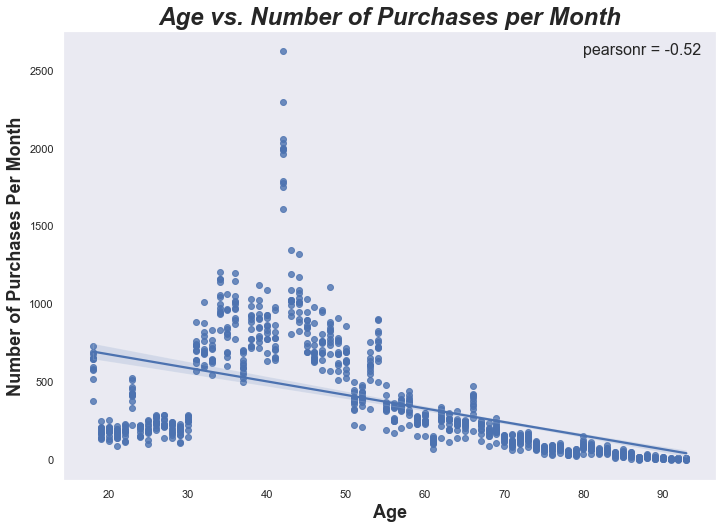

In [41]:
# Number of purchases per month
age_vs_month = sales_clean.copy()
age_vs_month["month"] = age_vs_month.date.dt.month.astype("category") # Create the variable month in the dataframe
# Group by month then age to have the number of purchase each month for each age
age_vs_month_plt= age_vs_month.groupby(["month", "age"]).count().reset_index()
# Pearson r
r_age_month = sci.pearsonr(age_vs_month_plt.age, age_vs_month_plt.id_prod)[0]

# Plot
sns.regplot(x = "age", y = "id_prod", data = age_vs_month_plt)
plt.xlabel("Age", fontsize = 18, fontweight = "bold")
plt.ylabel("Number of Purchases Per Month", fontsize = 18, fontweight = "bold")
plt.title("Age vs. Number of Purchases per Month", fontsize = 24, fontweight = "bold", fontstyle = "italic")
# Put the pearsonr in the plot as a legend
plt.text(s = "pearsonr = {:.2f}".format(r_age_month), x = 80, y = 2600, fontsize = 16)
plt.savefig("images/age_monthly_purchases.svg");

There is a correlation between the age and the number of purchases per month, as the age increases the number of purchases per month decreases.  
The number of purchases per month is higher for customers between 30 and 50 years old. 

### **Correlation between Age and the Categories of purchases products**

Our hypothesis.
>   `H0 : Age and Category are independant`  
    `H1: Age and Category are dependant`

In [ ]:
# Compute a group_age variable
def group_age(age:int) -> str:
    """return the group age of each age"""
    if age >= 18 and age < 35:
        return "18-34"
    elif age >= 35 and age < 61:
        return "35-60"
    elif age >= 61:
        return "61+"
# Create the group_age variable and turn it into category
sales_clean["group_age"] = sales_clean.age.apply(group_age).astype("category") 

In [ ]:
# Use the function to find the dependence and contingency table
result_1, table_1 = chi_squared(sales_clean, "category", "group_age")
# Plot the heatmap
sns.heatmap(table_1, annot = True, cbar = False)
plt.title("Correlation Between Age Group & Category", fontsize = 24, fontweight = "bold", fontstyle = "italic")
plt.xlabel("Age Group", fontsize = 18, fontweight = "bold")
plt.ylabel("Category", fontsize = 18, fontweight = "bold")
plt.savefig("images/heatmap_age_category.svg");

In [ ]:
# print the result of the test
result_1

For all ages there are more sales in category 0 and less in category 2.  
People aged between 35-60 make more purchases in category 0 and 1 compared to other age group.

**Correlation between age and the average basket size (in number of items)**

In [ ]:
# compute the average basket size
age_average_basket = sales_clean.groupby(["age", "session_id"]).count().reset_index().groupby("age")["id_prod"].mean().reset_index()
sns.regplot("age", "id_prod", data = age_average_basket, ci = False)
plt.xlabel("Age", fontsize = 18, fontweight = "bold")
plt.ylabel("Average Basket Size", fontsize = 18, fontweight = "bold")
plt.title("Age vs. Average Basket Size", fontsize = 24, fontweight = "bold", fontstyle = "italic")
r_age_average_basket = sci.pearsonr(age_average_basket.age, age_average_basket.id_prod)[0]
plt.text(s = "pearsonr = {:.2f}".format(r_age_average_basket), x = 75, y = 2.45, fontsize = 16)
plt.savefig("images/age_basket_size.svg");

There is a correlation between age and the average basket size.  
Young people (< 50 years old) have an average basket size higher than older people. As we could expect we have a pick
between people aged 30 to 50 years old which is the range where we have the highest sales.